<div class="alert alert-info"
     style="background-color:#008a79; color:white; padding:0px 10px; border-radius:10px;">
    <h1 style='margin:10px 5px'>Crypto: Predictive Model</h1>
</div>

### Content:
1. Load the Data
  - Import libraries
  - Load the datasets
  
  
2. DataFrame Preparation
  - Data Preprocessing 
  
  
3. Exploratory Data Analysis
  - Plotting Close price and two Moving Average
  - Plotting High Low and Moving Average
  - Plotting Moving Average and Confidence bands
  
  
4. Data Preparation for econometric analysis
  - Decomposition: trend, seasonality, residuals
  - Testing for Stationarity
  - Model Selection
  
  
5. Data Preparation for machine learning
  - Preparing DataFrame 
  - Features Engineering
  - Time Train Test split

  
6. Model Building
  - Train Model
  - Model Prediction
  - Model Evaluation
  - Alternative models

  
7. Improve Model
  - Hyperparameters Tuning
  - Save the Final Model

### 1. Load the data

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
import statsmodels.api as sm
from pmdarima.arima import auto_arima
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, SGDRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import pickle

In [37]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading crypto data from API
df = pd.read_json('https://api.cryptowat.ch/markets/binance-us/btcusd/ohlc?after=1451606400&periods=86400')
df

,result,allowance
86400,"[[1569283200, 10170, 10170, 10170, 10170, 0.01...",NaN
cost,NaN,0.015
remaining,NaN,9.985
upgrade,NaN,"For unlimited API access, create an account at..."


### 2. DataFrame preparation

In [3]:
# Define the function to preprocessing the data to have the daily OHLC dataset.
def preprocessing():
    '''  
    Preprocessing the data to have the daily OHLC dataset.
    Volume indicate the daily trading Volume in the crypto currency.
    QuoteVolume the daily trading Volume in USD.    
    '''
    crypto_copy = df.copy()
    crypto = pd.DataFrame(crypto_copy['result'].iloc[0], columns=('Close_Time','Open','High','Low','Close','Volume','QuoteVolume'))
    crypto['Close_Time'] = pd.to_datetime(crypto['Close_Time'], unit = 's')
    crypto.set_index('Close_Time', inplace=True)
    
    return crypto

In [4]:
# Create btc dataframe
btc = preprocessing()

In [5]:
btc

,Open,High,Low,Close,Volume,QuoteVolume
Close_Time,,,,,,
2019-09-24,10170.00,10170.00,10170.00,10170.00,0.010000,1.017000e+02
2019-09-25,9676.98,9676.98,7895.02,8570.86,81.193101,7.139468e+05
2019-09-26,8548.70,8723.64,8268.59,8439.02,30.195978,2.558026e+05
2019-09-27,8408.92,8452.45,7746.83,8059.86,41.977694,3.437113e+05
2019-09-28,8095.78,8273.24,7870.10,8189.20,36.261685,2.921455e+05
...,...,...,...,...,...,...
2022-09-06,19998.77,20058.00,19635.96,19795.12,4817.489036,9.539389e+07
2022-09-07,19795.12,20180.50,18668.90,18790.39,11753.830278,2.289762e+08
2022-09-08,18789.40,19462.02,18534.06,19290.53,8092.183326,1.533670e+08


### 3. Exploratory Data Analysis

In [6]:
# Define the function to plot Close price and two different MAs.
def plot_MA(crypto, window_i=5, window_j=25):
    '''   
    Visualized Close price, Volume with two different windows MA.
    Defaulf MA windows: (5), (25)
    '''
    fig = plt.subplots(figsize=(20,10))
 
    ax1 = plt.subplot2grid((6,1),(0,0), rowspan=5, colspan=1)
    ax1.plot(crypto.index, crypto['Close'])
    ax1.plot(crypto.index, crypto['Close'].rolling(window_i).mean(), label=f'MA({window_i})')
    ax1.plot(crypto.index, crypto['Close'].rolling(window_j).mean(), label=f'MA({window_j})')
    
    plt.title(f'Close prices with MA({window_i}) and MA({window_j})')
    plt.legend(loc='upper left')
    
    ax2 = plt.subplot2grid((6,1),(5,0), rowspan=1, colspan=1, sharex=ax1)
    ax2.fill_between(crypto.index, crypto['Volume'], 0)
       
    return plt.show();

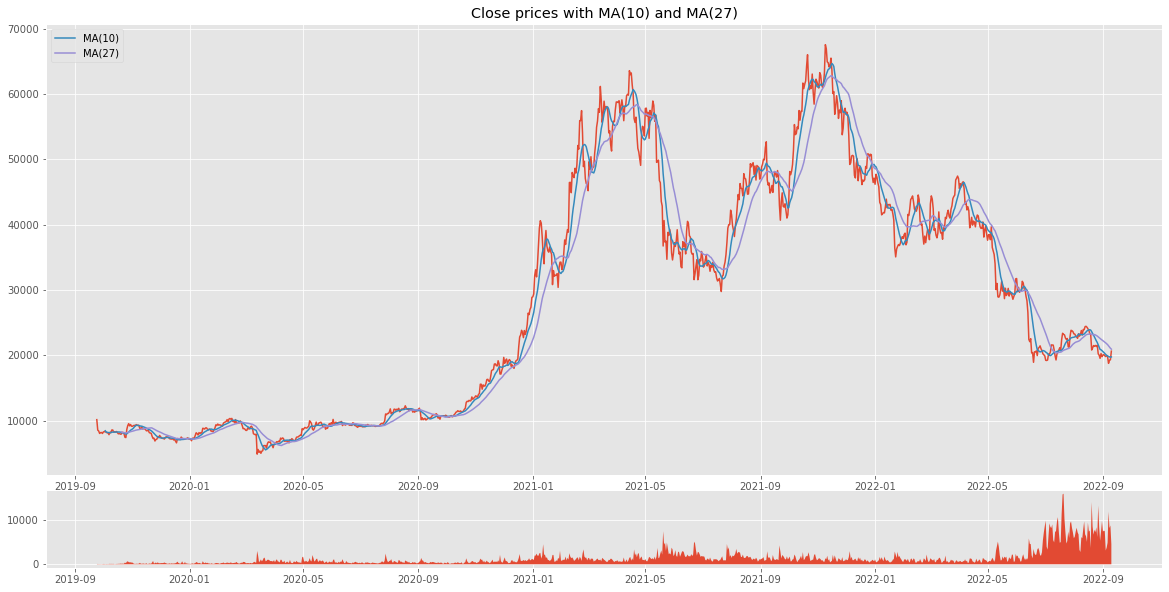

In [7]:
plot_MA(btc,10,27)

In [8]:
# Define the function to plot HL and MA.
def plot_HL(crypto, window=20):
    '''  
    Visualized High Low, MA, and Volume.
    Defaulf MA(20)
    '''
    fig = plt.subplots(figsize=(20,10))
    rolling_mean = crypto['Close'].rolling(window).mean()
    
    ax1 = plt.subplot2grid((6,1),(0,0), rowspan=5, colspan=1)
    ax1.plot(crypto.High, "r--", color='b', label='High / Low')
    ax1.plot(crypto.Low, "r--", color='b')
    ax1.plot(crypto.index, rolling_mean, label=f'MA({window})')
         
    plt.title(f'High Low, MA({window})')
    plt.legend(loc='upper left')
            
    ax2 = plt.subplot2grid((6,1),(5,0), rowspan=1, colspan=1, sharex=ax1)
    ax2.fill_between(crypto.index, crypto['Volume'], 0)
    
    return plt.show();

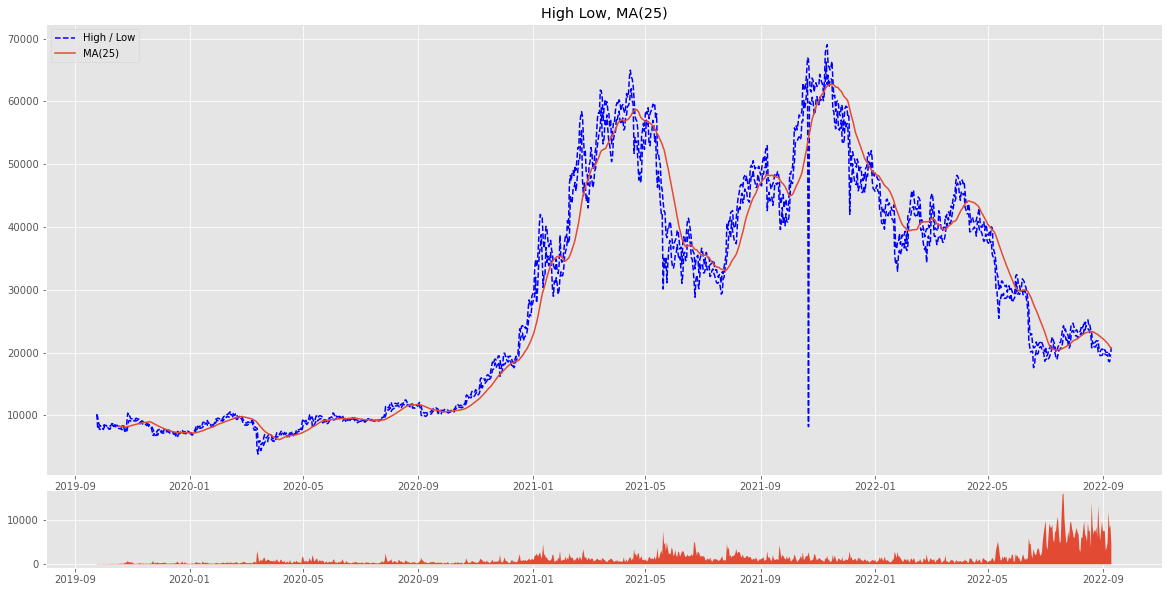

In [9]:
plot_HL(btc,25)

In [10]:
# Define the function to plot the MA and relative Confidence bands
def plot_conf(crypto, window=20, conf=False):
    '''    
    Visualized Close price, Volume with MA and Confidence bands.
    Defaulf MA(20)
    Optional conf=True
    '''
    fig = plt.subplots(figsize=(20,10))
    rolling_mean = crypto['Close'].rolling(window).mean()
    
    ax1 = plt.subplot2grid((6,1),(0,0), rowspan=5, colspan=1)
    ax1.plot(crypto.index, crypto['Close'])
    ax1.plot(crypto.index, rolling_mean, label=f'MA({window})')
    
    plt.title(f'Close prices and MA({window})')
    plt.legend(loc='upper left')
    
    if conf:
        mae = mean_absolute_error(crypto['Close'][window:], rolling_mean[window:])
        deviation = np.std(crypto['Close'][window:] - rolling_mean[window:])
        scale = 1.96
        lower_band = rolling_mean - (mae + scale * deviation)
        upper_band = rolling_mean + (mae + scale * deviation)
        ax1.plot(upper_band, "r--", color='b', label='Upper Band / Lower Band')
        ax1.plot(lower_band, "r--", color='b')
        plt.title(f'Close prices, MA({window}) and confidence bands')
        plt.legend(loc='upper left')
        
    ax2 = plt.subplot2grid((6,1),(5,0), rowspan=1, colspan=1, sharex=ax1)
    ax2.fill_between(crypto.index, crypto['Volume'], 0)
     
    return plt.show();

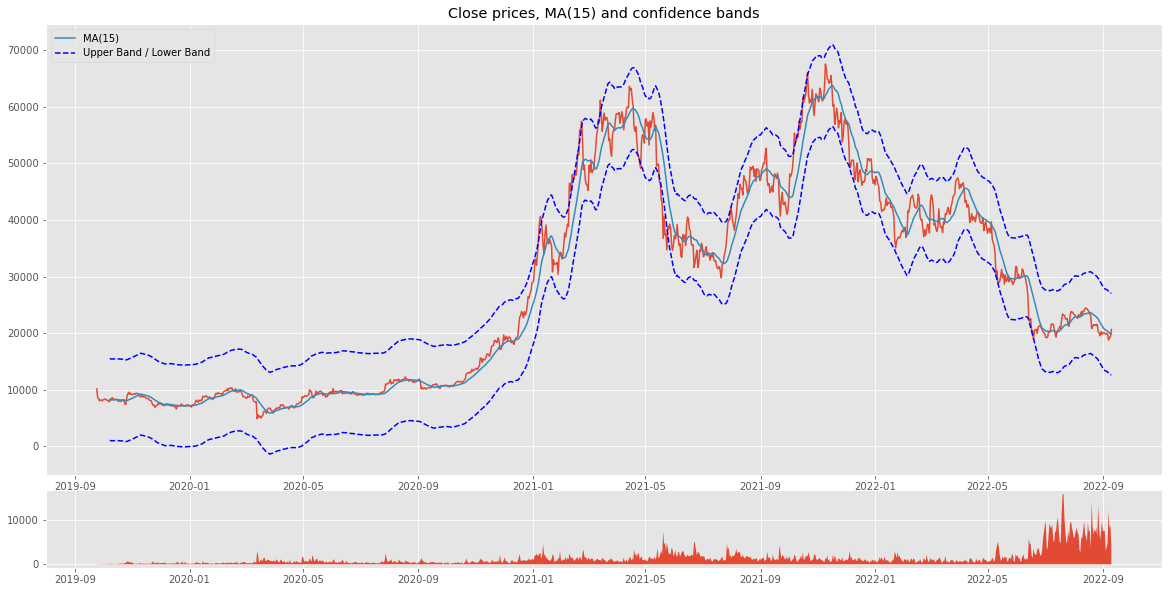

In [11]:
plot_conf(btc,15,conf=True)

### 4. Data Preparation for econometric analysis

In [12]:
# Decomposing the series in 3 partes: trend, seasonality and residuals.
dec_Close = seasonal_decompose(btc.Close, model='multiplicative')
dec_Volume = seasonal_decompose(btc.Volume, model='multiplicative')

In [13]:
# Define the function to visual decomposing and test for Stationarity
def testing_stationarity(crypto):
    '''    
    Visualized Close price, Volume trends decomposed.
    '''
    fig = plt.subplots(figsize=(20,20))
    
    ax1 = plt.subplot2grid((4,2), (0,0))
    ax1.plot(crypto.Close)
    ax1.get_xaxis().set_visible(False)
    ax1.legend(['original'], loc='upper left')
    ax1.set_title('Close')

    ax2 = plt.subplot2grid((4,2), (1,0))
    ax2.plot(dec_Close.trend,  color='k')
    ax2.get_xaxis().set_visible(False)
    ax2.legend(['trend'], loc='upper left')

    ax3 = plt.subplot2grid((4,2), (2,0))
    ax3.plot(dec_Close.seasonal,  color='k')
    ax3.get_xaxis().set_visible(False)
    ax3.legend(['seasonality'], loc='upper left')

    ax4 = plt.subplot2grid((4,2), (3,0))
    ax4.plot(dec_Close.resid,  color='k')
    ax4.legend(['residual'], loc='upper left')

    ax5 = plt.subplot2grid((4,2), (0,1))
    ax5.plot(btc.Volume)
    ax5.get_xaxis().set_visible(False)
    ax5.legend(['original'], loc='upper left')
    ax5.set_title('Volume')

    ax6 = plt.subplot2grid((4,2), (1,1))
    ax6.plot(dec_Volume.trend,  color='k')
    ax6.get_xaxis().set_visible(False)
    ax6.legend(['trend'], loc='upper left')

    ax7 = plt.subplot2grid((4,2), (2,1))
    ax7.plot(dec_Volume.seasonal,  color='k')
    ax7.get_xaxis().set_visible(False)
    ax7.legend(['seasonality'], loc='upper left')

    ax8 = plt.subplot2grid((4,2), (3,1))
    ax8.plot(dec_Volume.resid,  color='k')
    ax8.legend(['residual'], loc='upper left')

    plt.tight_layout()
    plt.subplots_adjust(hspace=0)
   
    return plt.show();

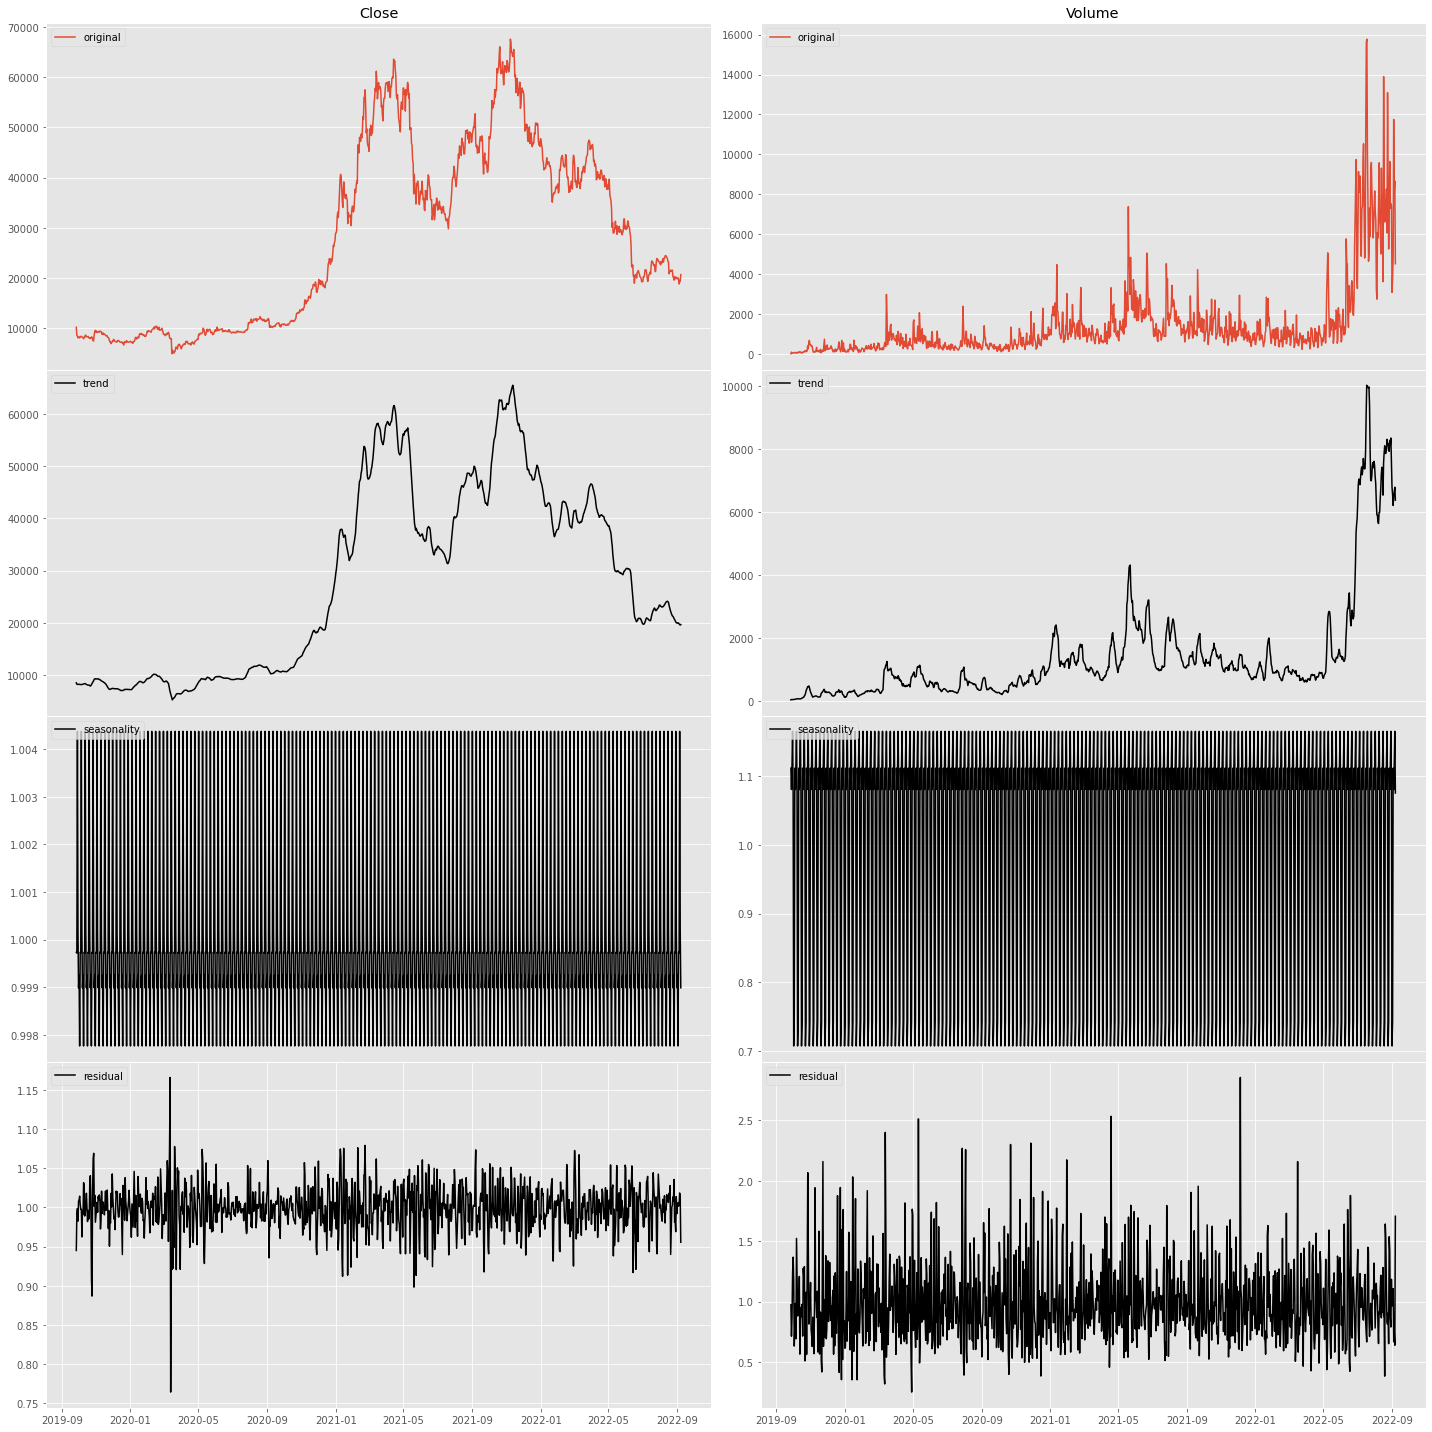

In [14]:
testing_stationarity(btc)

As expected **btc close price is a non-stationary process**. It appears to have no long-run mean to which the series returns so no long-term equilibrium, nor mean reversion of Close price variable. Residuals variance looks high. Recommend log-differencing to smooth the series.

In [15]:
# First differencing order btc close price to detrendalize the serie.
btc['Log_return'] = np.log(btc['Close']).diff()
btc = btc.dropna()

In [16]:
# Plot Log return, mean and std dev.
def plot_log_return(crypto):
    '''  
    Visualize Log return, Mean, Std.
    '''
    fig = plt.subplots(figsize=(20,10))
    mean = crypto.Log_return.rolling(15).mean()
    std = crypto.Log_return.rolling(15).std()

    plt.plot(crypto.index, crypto['Log_return'])
    plt.plot(mean, 'k:', label='Mean')
    plt.plot(std, 'k-', label = 'Std Dev')
    
    plt.title('Log return, Mean, Std Dev')
    plt.legend(loc='upper left')
   
    return plt.show();

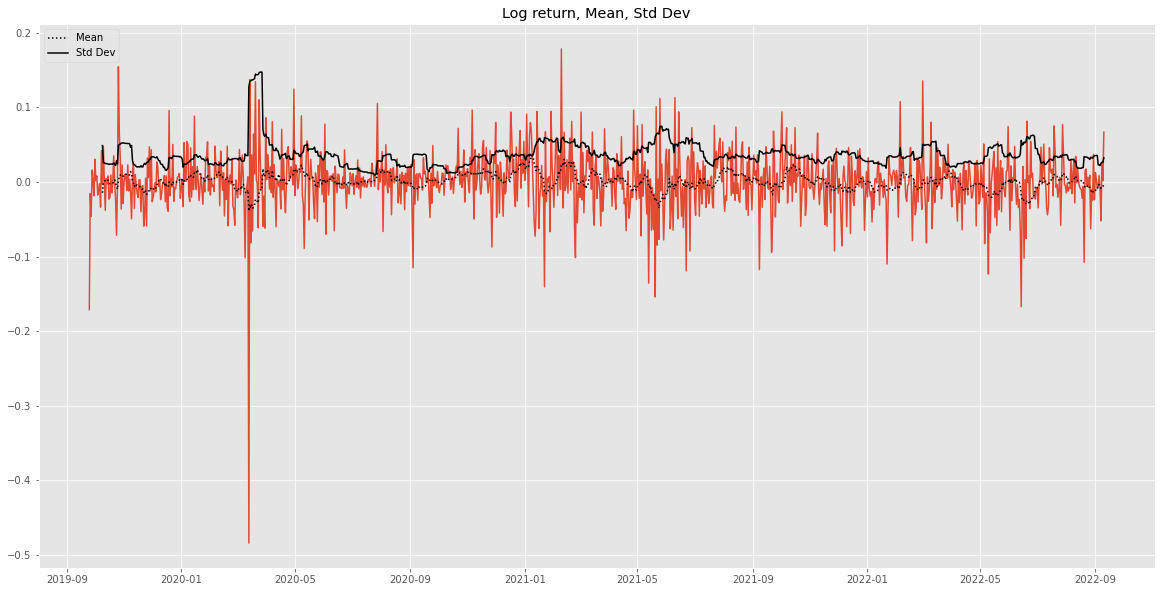

In [17]:
plot_log_return(btc)

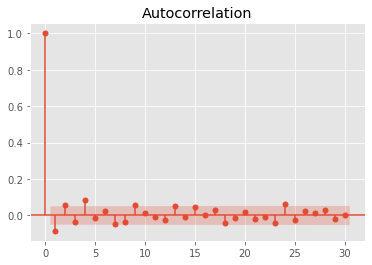

In [18]:
Close_acf = plot_acf(btc['Log_return'], lags=30, alpha=0.1)

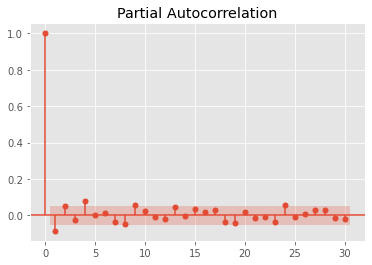

In [19]:
Close_pacf = plot_pacf(btc['Log_return'], lags=30, alpha=0.1)

Both Autocorrelation and Partial Autocorrelation suggest an ARIMA(1,0,1) model.

In [20]:
# Using Auto ARIMA to confirm the assumptions on the best model.
auto_arima_model = auto_arima(btc.Log_return, m=12, with_intercept=False, suppress_warnings=True)
print(auto_arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1082
Model:               SARIMAX(1, 0, 1)   Log Likelihood                1948.142
Date:                Fri, 09 Sep 2022   AIC                          -3890.284
Time:                        08:55:05   BIC                          -3875.325
Sample:                             0   HQIC                         -3884.621
                               - 1082                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7261      0.122     -5.933      0.000      -0.966      -0.486
ma.L1          0.6462      0.134      4.812      0.000       0.383       0.909
sigma2         0.0016   2.09e-05     76.463      0.0

Auto ARIMA confirms the assumptions on the best model, so an ARIMA(1,0,1) is used.

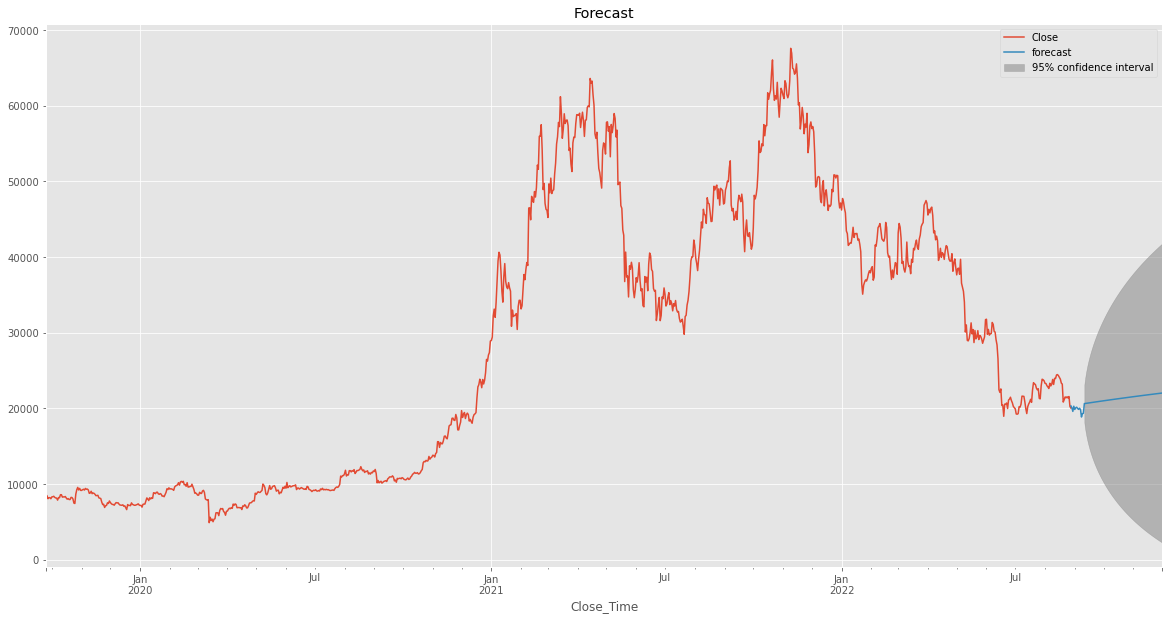

In [49]:
model = sm.tsa.ARIMA(btc.Close, order=(1,0,1), freq='D').fit()

fig, ax = plt.subplots(figsize=(20,10))

ax = btc['Close'].loc['2019-09-24':'2022-08-28'].plot(ax=ax, title='Forecast')
ax = model.plot_predict(start='2022-08-28 00:00:00', 
                        end='2022-12-01 00:00:00', 
                        dynamic=False, ax=ax,
                        plot_insample=False)

### 5. Data preparation for Machine Learning

In [22]:
# Preparing the ML dataFrame
btc_ml = pd.DataFrame(btc.Close.copy())
btc_ml.columns = ['y']
btc_ml.y

Close_Time
2019-09-25     8570.86
2019-09-26     8439.02
2019-09-27     8059.86
2019-09-28     8189.20
2019-09-29     8205.15
                ...   
2022-09-06    19795.12
2022-09-07    18790.39
2022-09-08    19290.53
2022-09-09    19322.54
2022-09-10    20658.35
Name: y, Length: 1082, dtype: float64

In [23]:
# Feature engineering: adding lag features
for i in range(5, 30):
    btc_ml[f"lag_{i}"] = btc_ml.y.shift(i)

In [24]:
btc_ml.tail(10)

,y,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,...,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29
Close_Time,,,,,,,,,,,,,,,,,,,,,
2022-09-01,20060.32,20243.48,21558.82,21367.42,21528.61,21397.00,21512.28,21141.95,20829.32,23198.25,...,23940.07,23964.88,23155.85,23816.87,23177.81,22959.28,23317.38,22622.27,22824.55,22990.75
2022-09-02,20132.97,20039.86,20243.48,21558.82,21367.42,21528.61,21397.00,21512.28,21141.95,20829.32,...,24412.39,23940.07,23964.88,23155.85,23816.87,23177.81,22959.28,23317.38,22622.27,22824.55
2022-09-03,19954.16,19552.34,20039.86,20243.48,21558.82,21367.42,21528.61,21397.00,21512.28,21141.95,...,24458.58,24412.39,23940.07,23964.88,23155.85,23816.87,23177.81,22959.28,23317.38,22622.27
2022-09-04,19832.06,20290.00,19552.34,20039.86,20243.48,21558.82,21367.42,21528.61,21397.00,21512.28,...,24315.55,24458.58,24412.39,23940.07,23964.88,23155.85,23816.87,23177.81,22959.28,23317.38
2022-09-05,20002.38,19812.65,20290.00,19552.34,20039.86,20243.48,21558.82,21367.42,21528.61,21397.00,...,24096.82,24315.55,24458.58,24412.39,23940.07,23964.88,23155.85,23816.87,23177.81,22959.28
2022-09-06,19795.12,20060.32,19812.65,20290.00,19552.34,20039.86,20243.48,21558.82,21367.42,21528.61,...,23855.35,24096.82,24315.55,24458.58,24412.39,23940.07,23964.88,23155.85,23816.87,23177.81
2022-09-07,18790.39,20132.97,20060.32,19812.65,20290.00,19552.34,20039.86,20243.48,21558.82,21367.42,...,23335.92,23855.35,24096.82,24315.55,24458.58,24412.39,23940.07,23964.88,23155.85,23816.87
2022-09-08,19290.53,19954.16,20132.97,20060.32,19812.65,20290.00,19552.34,20039.86,20243.48,21558.82,...,23198.25,23335.92,23855.35,24096.82,24315.55,24458.58,24412.39,23940.07,23964.88,23155.85
2022-09-09,19322.54,19832.06,19954.16,20132.97,20060.32,19812.65,20290.00,19552.34,20039.86,20243.48,...,20829.32,23198.25,23335.92,23855.35,24096.82,24315.55,24458.58,24412.39,23940.07,23964.88


In [25]:
# Creating X, y
X = btc_ml.dropna().drop(['y'], axis=1)
y = btc_ml.dropna().y

In [26]:
# Define a function to split train, test time series data
def time_series_train_test_split(X, y, test_size):
    '''   
    Train-test split for time series data structure.    
    '''
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [27]:
btc_pred = btc_ml.copy()
# Feature engineering: adding lag features predict
for i in range(1, 5):
    btc_pred[f"lag_{i}"] = btc_pred.y.shift(i)

In [28]:
# Train test split
X_train, X_test, y_train, y_test = time_series_train_test_split(X, y, test_size=0.3)

# Scale the data for regression algorithms
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define function for MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### 6. Model Building

In [29]:
# Loading and fit the model
linear = LinearRegression()

linear.fit(X_train_scaled, y_train)

LinearRegression()

In [30]:
# Define a plot function for the results
def plot_results(model, X_train=X_train, X_test=X_test, plot_intervals=False):
    '''      
    Plot model results with prediction intervals.
    '''
    
    y_pred = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(btc_ml.index[-len(y_pred):], y_pred, 'g', label='prediction', linewidth=2.0)
    plt.plot(btc_ml.index[-len(y_pred):], y_test, label='actual', linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=TimeSeriesSplit(n_splits=5), 
                                    scoring='neg_mean_absolute_error')
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = y_pred - (mae + scale * deviation)
        upper = y_pred + (mae + scale * deviation)
        
        plt.plot(btc_ml.index[-len(y_pred):], lower, 'r--', label='upper band / lower band', alpha=0.5)
        plt.plot(btc_ml.index[-len(y_pred):], upper, 'r--', alpha=0.5)
    
    error = mean_absolute_percentage_error(y_pred, y_test)
    plt.title('Mean absolute percentage error: {0:.2f}%'.format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

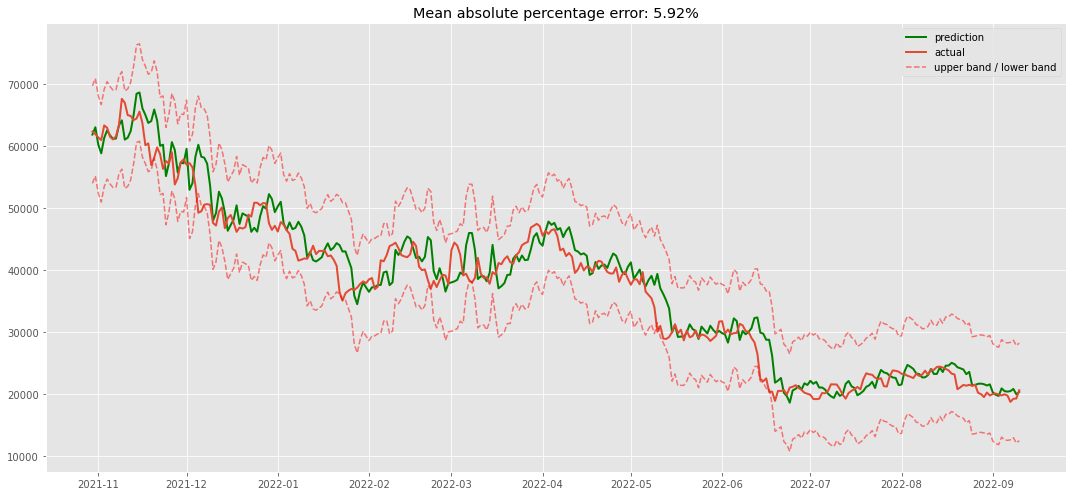

In [31]:
plot_results(linear, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)

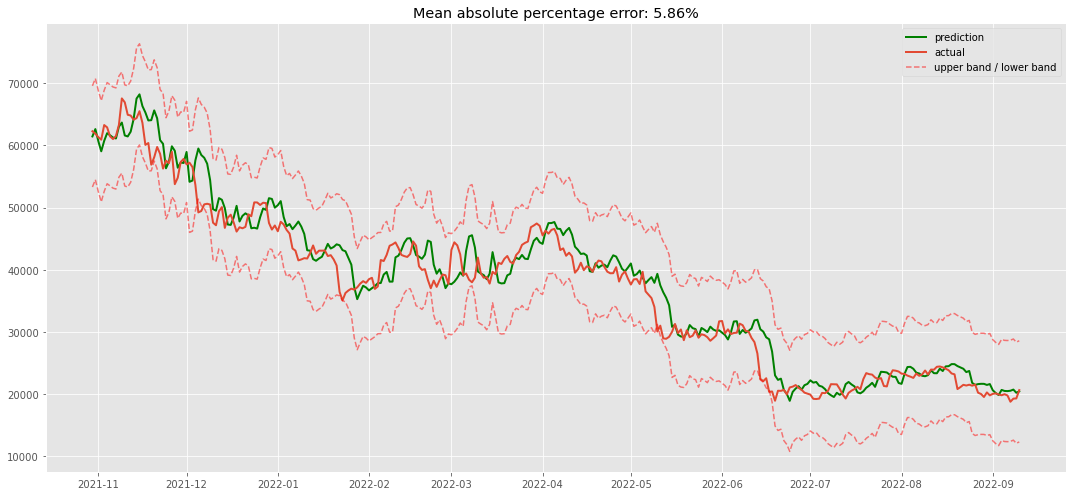

In [32]:
# Fitting RidgeCV
ridge = RidgeCV()

ridge.fit(X_train_scaled, y_train)

plot_results(ridge, 
             X_train=X_train_scaled, 
             X_test=X_test_scaled, 
             plot_intervals=True)

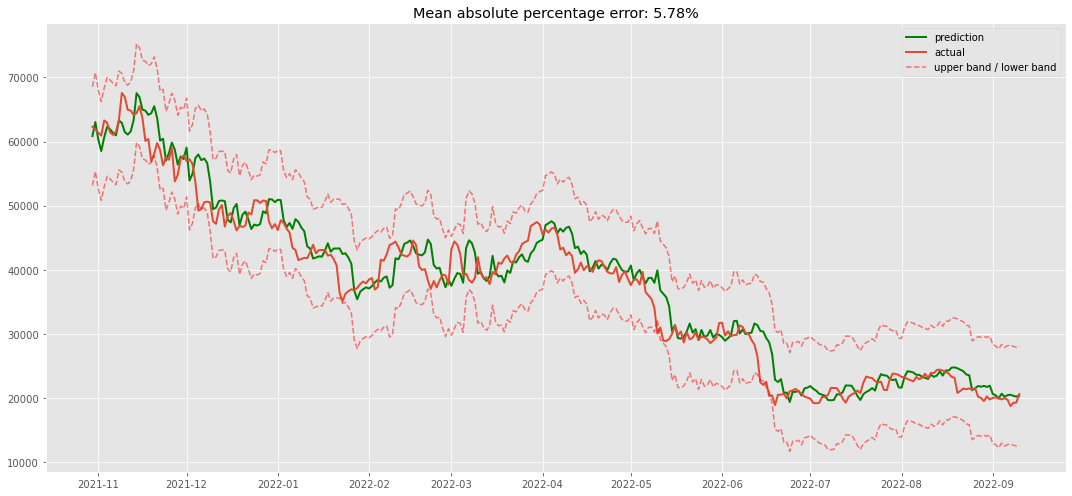

In [33]:
# Fitting LassoCV
lasso = LassoCV()

lasso.fit(X_train_scaled, y_train)

plot_results(lasso, 
             X_train=X_train_scaled, 
             X_test=X_test_scaled, 
             plot_intervals=True)

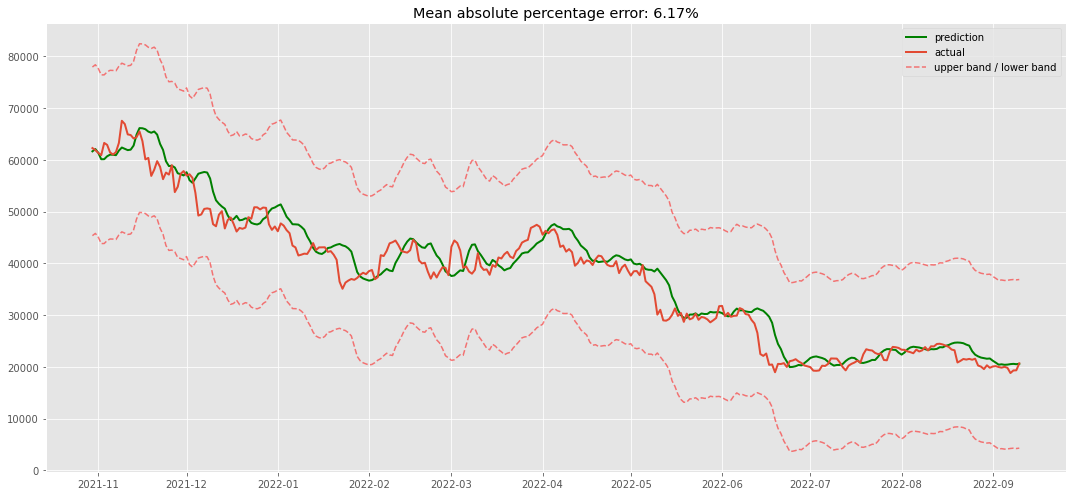

In [50]:
# Fitting SGDRegressor
SGDRegressor = SGDRegressor()

SGDRegressor.fit(X_train_scaled, y_train)

plot_results(SGDRegressor, 
             X_train=X_train_scaled, 
             X_test=X_test_scaled, 
             plot_intervals=True)

### 7. Improve Model

In [51]:
# Define the parameters grid for LassoCV
param_grid_LassoCV = {'n_alphas'   : [3,5,7,10],
                      'max_iter' : [1200,1500,2000,2500]        
                      } 

In [52]:
# Run grid search
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(lasso, 
                    param_grid=param_grid_LassoCV, 
                    verbose=3, 
                    n_jobs=-1) 

In [53]:
# Fit the model for grid search 
grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(estimator=LassoCV(), n_jobs=-1,
             param_grid={'max_iter': [1200, 1500, 2000, 2500],
                         'n_alphas': [3, 5, 7, 10]},
             verbose=3)

In [54]:
grid.best_estimator_

LassoCV(max_iter=1200, n_alphas=10)

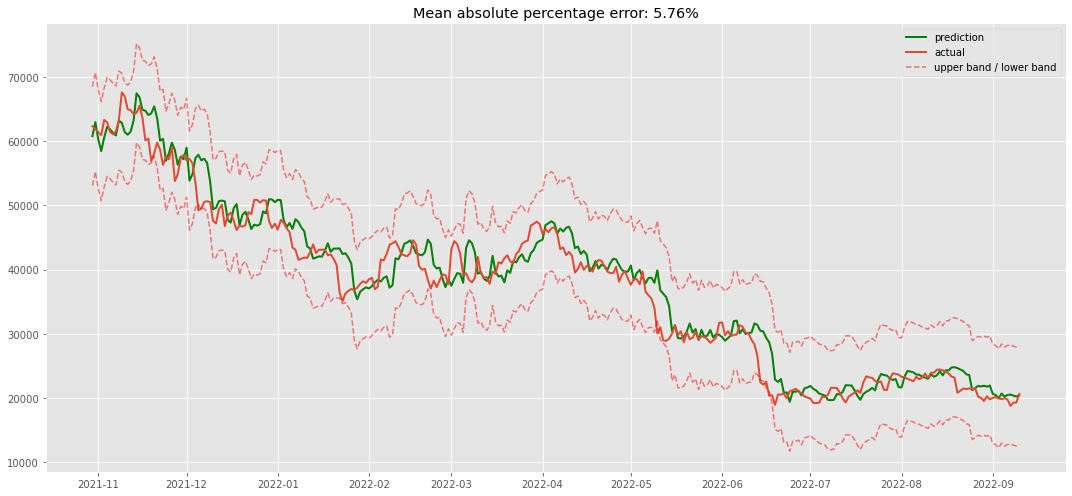

In [55]:
lasso = LassoCV(max_iter=1200, n_alphas=10)

lasso.fit(X_train_scaled, y_train)

plot_results(lasso, 
             X_train=X_train_scaled, 
             X_test=X_test_scaled, 
             plot_intervals=True)

In [ ]:
# Save the model 
filename = 'final_model_crypto.sav'
pickle.dump(grid.best_estimator_, open(filename, 'wb'))

In [ ]:
# Load the model
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model